# Age Estimation From Face Images

## Part I - Showing The Data

### Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import math
import scipy.spatial
import glob
import sklearn
import warnings
import base64
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from collections import Counter
from skimage.morphology import disk
from zipfile import ZipFile
from io import BytesIO
from PIL import Image
from IPython.core.display import display,HTML
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

### Reading Files and Creating Dataframe

I created a dataframe using 'Hw_Data.csv' file. <br>
I opened the assignment_images file and took images into a list named 'images'.

In [2]:
df = pd.read_csv("Hw_Data.csv")

In [3]:
images = []
for i in range(0,900):
    for filename in glob.glob('assignment_images/' + df['Name'][i]):
        im=Image.open(filename)
        images.append(im)

### Data Preprocessing

I splitted the names and ages to connect photos and ages.

In [4]:
age_list = []
name_list = []
for i in df['Name']:
    list_of_letters = list(i)
    agex = list_of_letters[4]+list_of_letters[5]
    namex = list_of_letters[0]+list_of_letters[1]+list_of_letters[2]+list_of_letters[3]+list_of_letters[4]+list_of_letters[5]
    age_list.append(agex) #creating a list of ages
    name_list.append(namex) #creating a list of names
df['Age'] = age_list
df['Age'] = df['Age'].astype(int)

### Showing Images in Dataframe for Visual Perspective

In [5]:
new_images = []
for i in range (0,900):
    image = images[i]
    image = image.resize((64,64)) 
    new_images.append(image)
df['Images'] = new_images

In [6]:
def get_thumbnail(path):
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

### Dataframe with Images

,Name,Age,Images
0,055A12.JPG,12,
1,016A03.JPG,3,
2,054A06.JPG,6,
3,053A06.JPG,6,
4,080A02.JPG,2,
5,001A08.JPG,8,
6,033A14.JPG,14,
7,032A15.JPG,15,
8,011A15.JPG,15,
9,042A20.JPG,20,

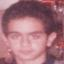
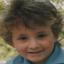
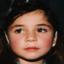
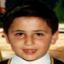
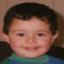
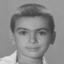
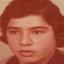
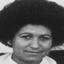
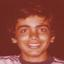
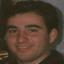
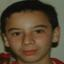
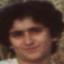
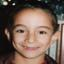
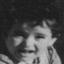
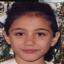
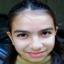
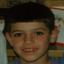
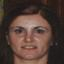
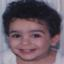
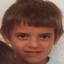
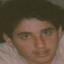
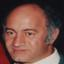
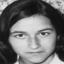
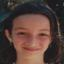
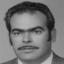
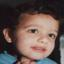
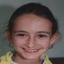
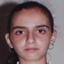
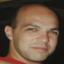
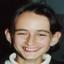
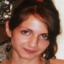
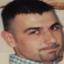
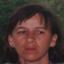
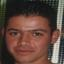
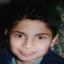
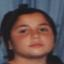
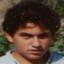
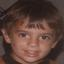
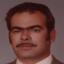
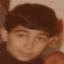
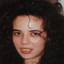
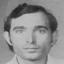
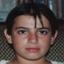
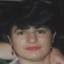
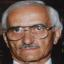
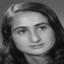
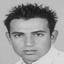
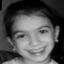
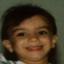
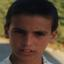
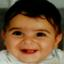
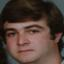
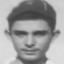
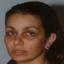
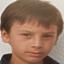
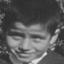
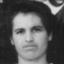
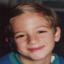
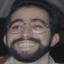
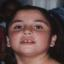
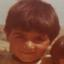
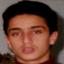
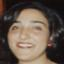
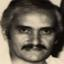
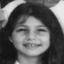
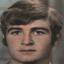
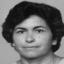
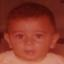
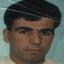
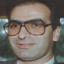
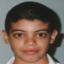
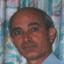
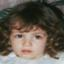
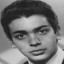
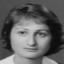
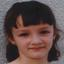
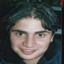
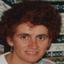
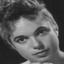
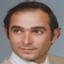
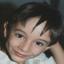
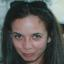
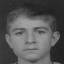
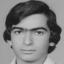
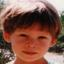
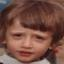
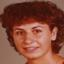
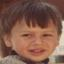
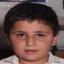
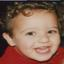
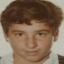
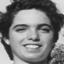
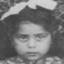
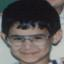
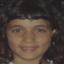
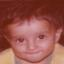
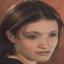
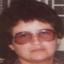
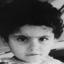
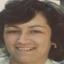
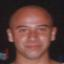
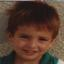
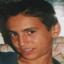
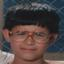
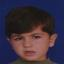
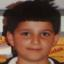
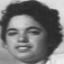
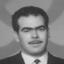
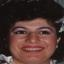
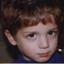
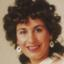
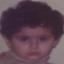
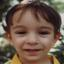
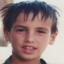
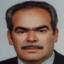
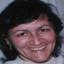
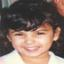
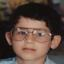
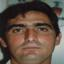
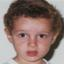
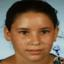
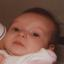
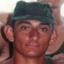
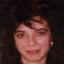
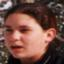
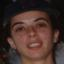
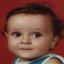
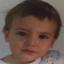
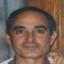
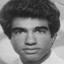
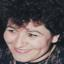
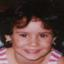
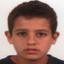
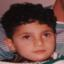
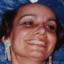
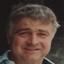
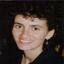
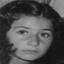
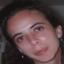
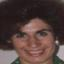
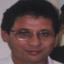
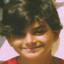
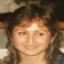
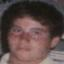
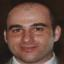
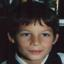
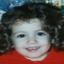
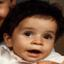
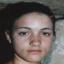
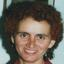
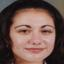
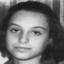
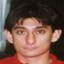
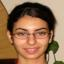
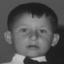
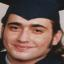
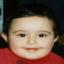
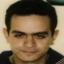
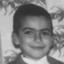
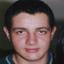
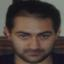
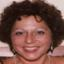
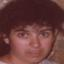
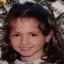
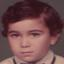
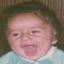
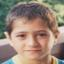
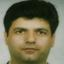
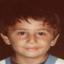
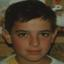
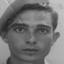
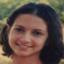
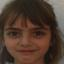
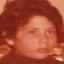
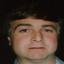
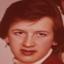
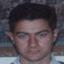
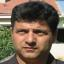
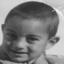
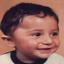
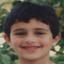
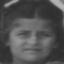
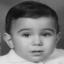
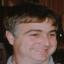
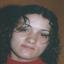
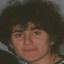
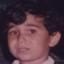
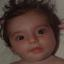
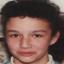
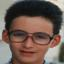
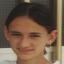
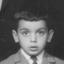
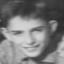
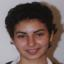
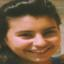
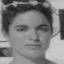
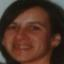
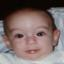
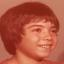
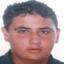
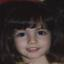
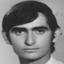
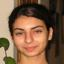
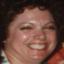
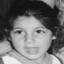
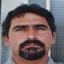
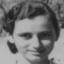
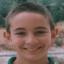
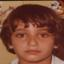
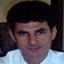
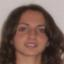
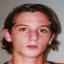
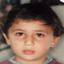
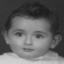
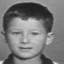
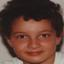
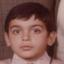
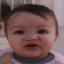
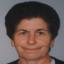
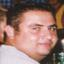
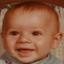
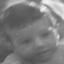
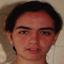
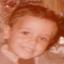
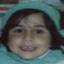
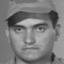
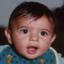
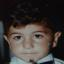
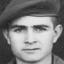
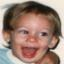
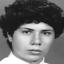
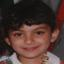
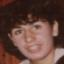
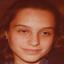
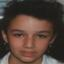
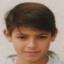
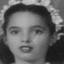
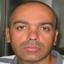
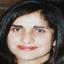
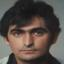
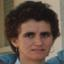
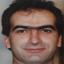
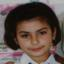
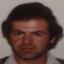
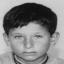
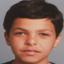
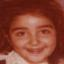
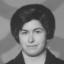
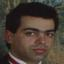
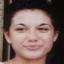
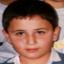
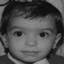
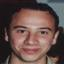
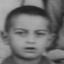
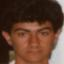
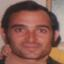
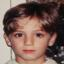
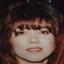
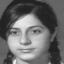
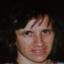
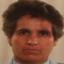
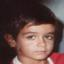
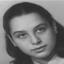
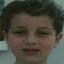
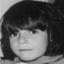
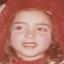
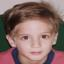
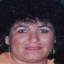
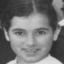
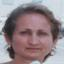
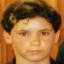
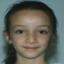
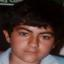
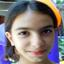
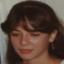
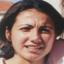
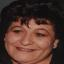
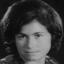
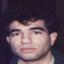
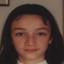
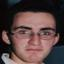
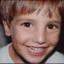
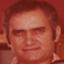
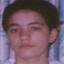
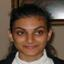
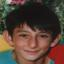
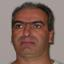
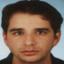
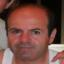
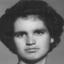
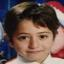
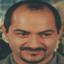
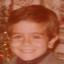
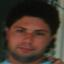
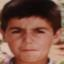
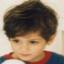
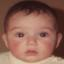
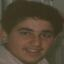
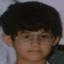
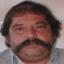
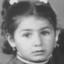
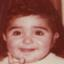
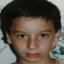
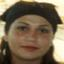
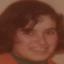
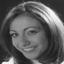
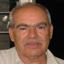
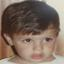
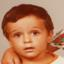
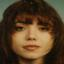
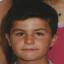
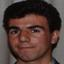
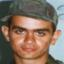
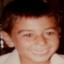
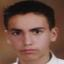
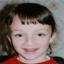
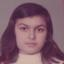
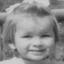
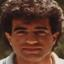
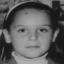
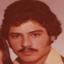
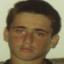
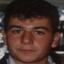
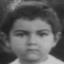
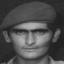
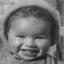
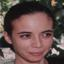
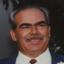
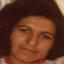
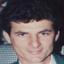
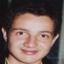
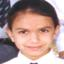
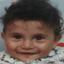
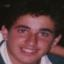
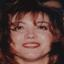
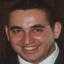
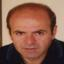
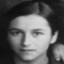
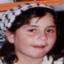
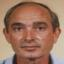
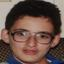
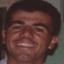
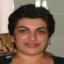
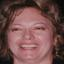
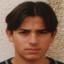
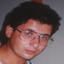
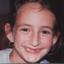
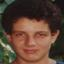
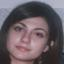
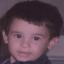
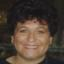
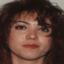
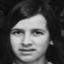
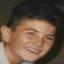
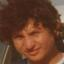
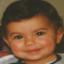
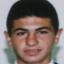
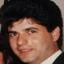
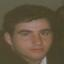
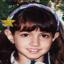
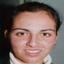
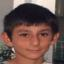
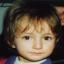
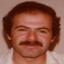
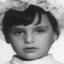
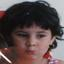
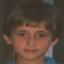
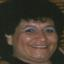
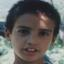
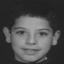
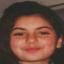
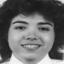
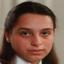
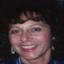
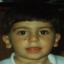
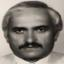
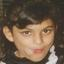
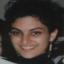
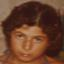
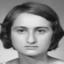
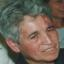
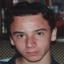
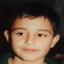
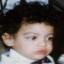
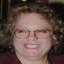
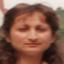
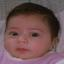
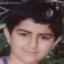
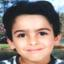
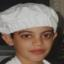
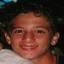
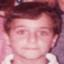
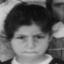
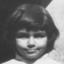
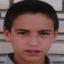
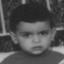
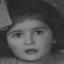
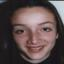
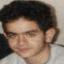
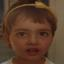
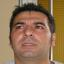
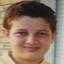
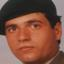
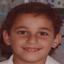
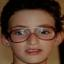
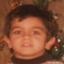
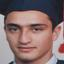
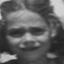
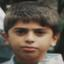
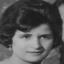
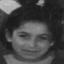
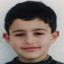
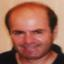
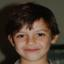
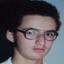
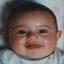
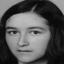
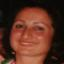
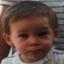
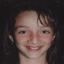
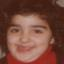
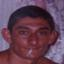
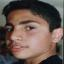
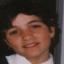
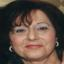
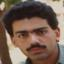
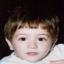
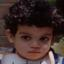
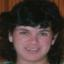
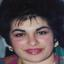
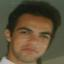
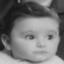
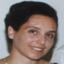
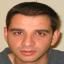
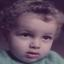
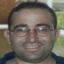
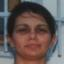
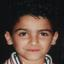
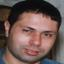
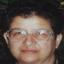
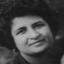
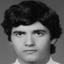
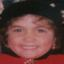
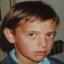
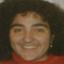
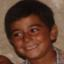
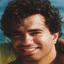
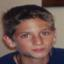
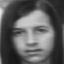
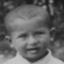
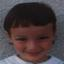
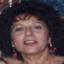
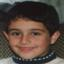
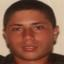
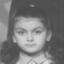
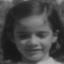
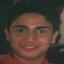
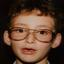
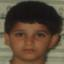
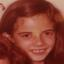
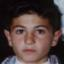
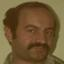
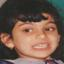
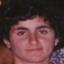
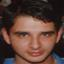
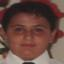
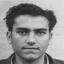
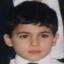
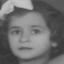
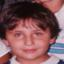
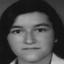
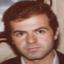
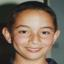
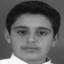
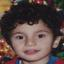
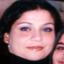
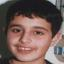
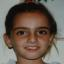
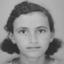
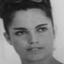
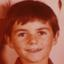
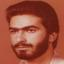
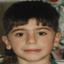
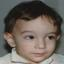
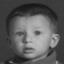
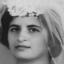
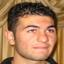
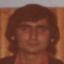
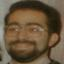
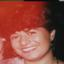
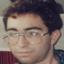
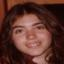
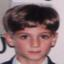
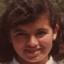
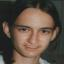
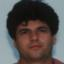
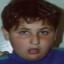
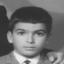
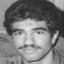
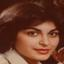
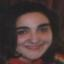
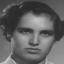
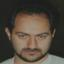
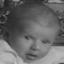
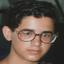
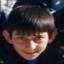
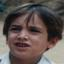
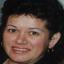
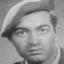
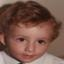
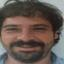
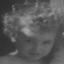
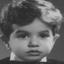
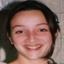
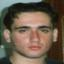
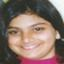
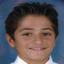
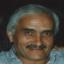
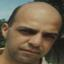
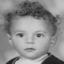
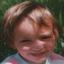
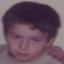
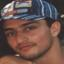
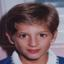
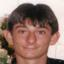
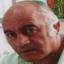
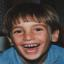
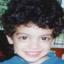
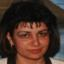
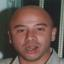
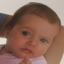
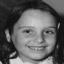
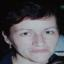
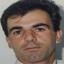
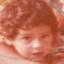
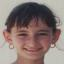
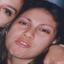
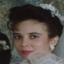
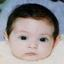
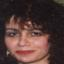
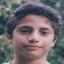
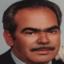
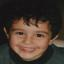
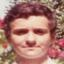
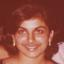
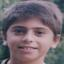
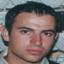
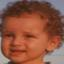
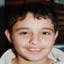
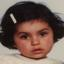
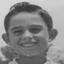
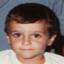
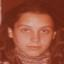
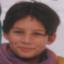
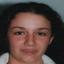
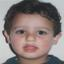
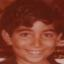
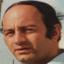
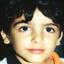
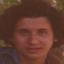
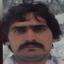
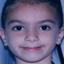
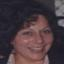
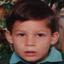
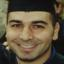
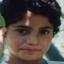
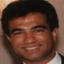
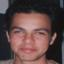
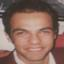
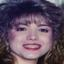
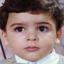
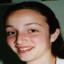
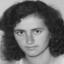
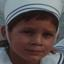
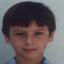
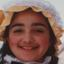
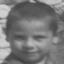
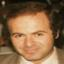
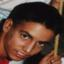
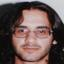
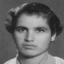
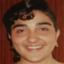
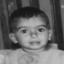
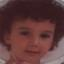
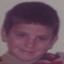
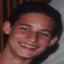
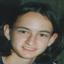
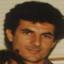
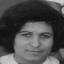
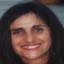
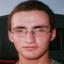
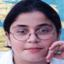
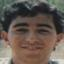
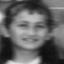
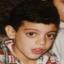
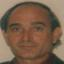
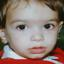
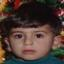
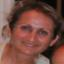
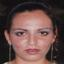
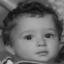
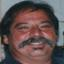
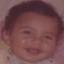
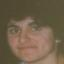
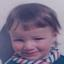
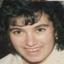
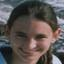
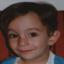
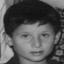
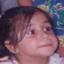
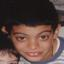
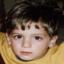
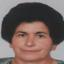
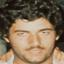
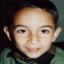
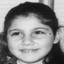
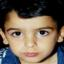
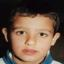
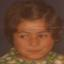
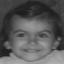
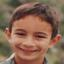
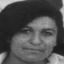
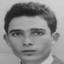
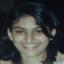
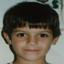
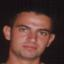
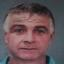
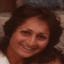
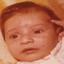
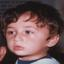
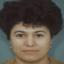
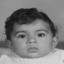
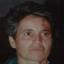
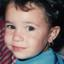
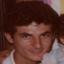
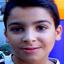
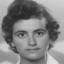
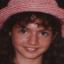
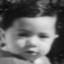
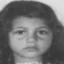
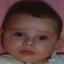
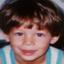
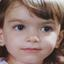
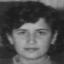
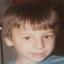
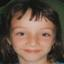
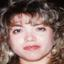
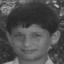
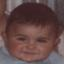
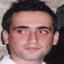
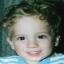
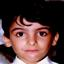
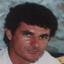
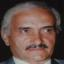
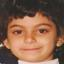
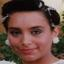
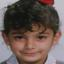
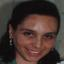
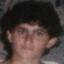
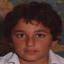
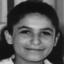
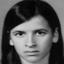
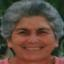
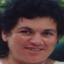
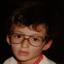
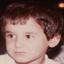
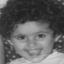
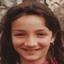
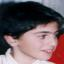
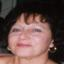
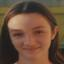
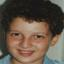
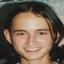
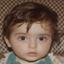
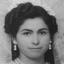
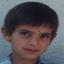
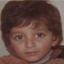
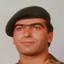
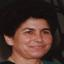
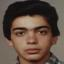
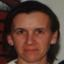
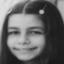
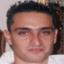
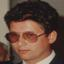
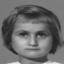
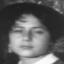
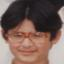
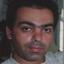
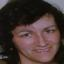
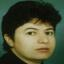
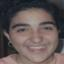
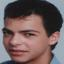
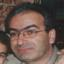
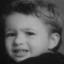
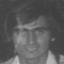
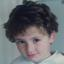
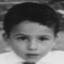
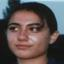
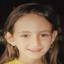
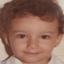
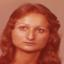
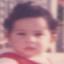
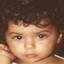
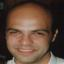
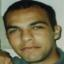
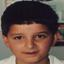
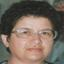
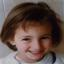
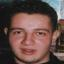
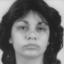
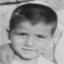
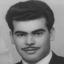
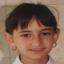
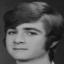
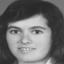
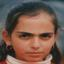
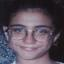
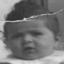
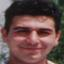
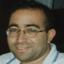
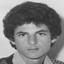
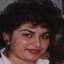
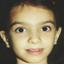
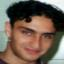
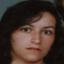
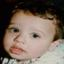
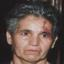
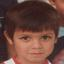
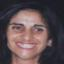
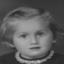
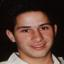
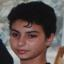
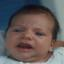
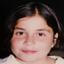
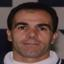
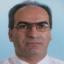
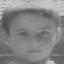
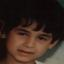
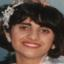
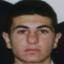
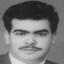
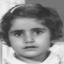
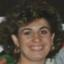
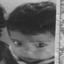
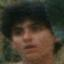
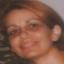
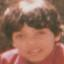
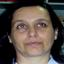
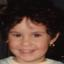
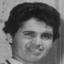
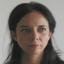
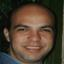
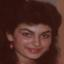
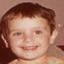
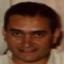
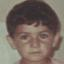
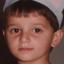
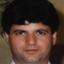
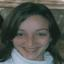
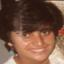
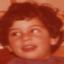
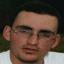
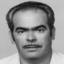
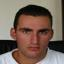
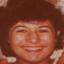
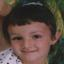
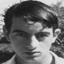
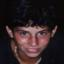
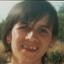
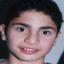
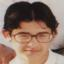
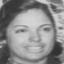
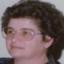
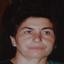
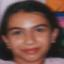
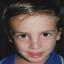
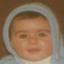
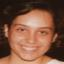
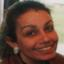
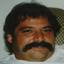
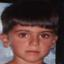
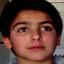
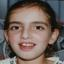
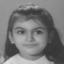
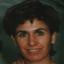
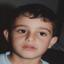
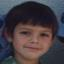
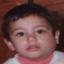
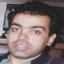
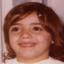
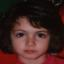
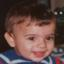
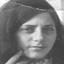
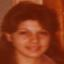
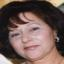
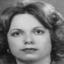
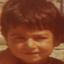
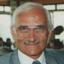
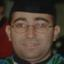
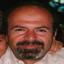
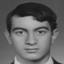
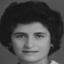
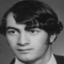
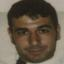
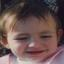
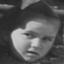
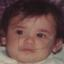
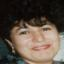
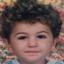
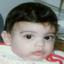
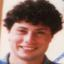
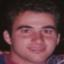
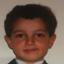
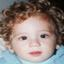
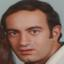
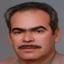
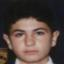
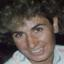
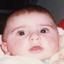
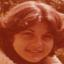
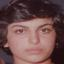
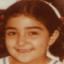
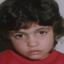
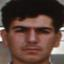
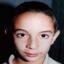
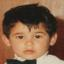
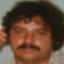
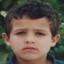
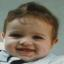
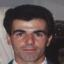
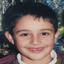
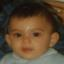
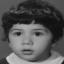
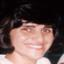
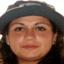
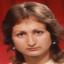
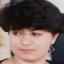
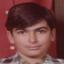
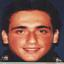
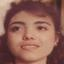
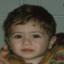
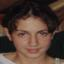
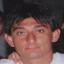
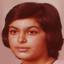
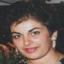
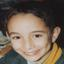
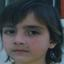
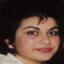
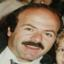
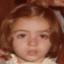
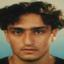
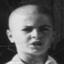
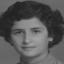
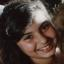
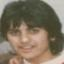
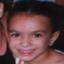
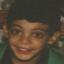
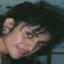
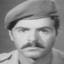
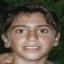
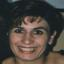
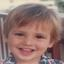
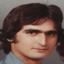
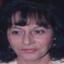
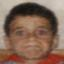
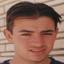
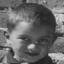
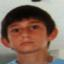
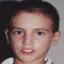
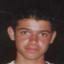
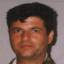
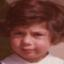
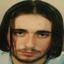
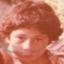
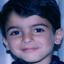
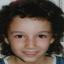
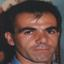
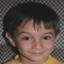
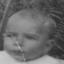
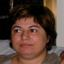
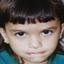
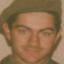
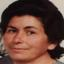
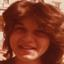
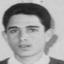
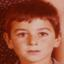
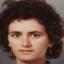
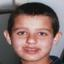
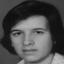
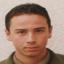
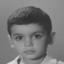
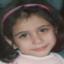
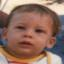
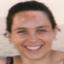
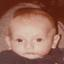
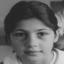
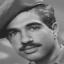
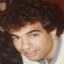
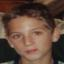
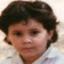

In [7]:
HTML(df.to_html(formatters = {
   'Images': image_formatter
}, escape = False, border = 3)) #visual data

## Part II - Processing Image Data

### Reading Images from File

I read images into a list named 'data'.

In [8]:
data = []
for i in range(0,900):
    for filename in glob.glob('assignment_images/' + df['Name'][i]): #reading images from file
        im=Image.open(filename)
        data.append(im)

### Grayscaling Images

Some of images are gray, some of coloured. Making all of them gray is the best way.

In [9]:
gray_list = [] 
for i in range(0,900):
    color_img = data[i]
    img = color_img.convert('L') #change the color to gray
    gray_list.append(img)

### Resizing Images

Resizing all the images to (64,64) it makes easier to learn.

In [10]:
resized_images = []
for i in range (0,900):
    image = gray_list[i]
    image = image.resize((64,64),Image.HAMMING) #resizing to (64,64)
    resized_images.append(image)

### Entropy Filtering Images

I used the entropy filter because it can detect subtle variations in the local gray level distribution.

In [11]:
entropy_list = []
for i in range(0,900):
    img = np.array(resized_images[i])
    entropy_image = entropy(img,disk(5)) #applying entropy filter
    entropy_list.append(entropy_image)

### Blurring Images

Blurring is another way that processing the images

In [12]:
blur_list = []
for i in range(0,900):
    img = entropy_list[i]
    img_blur = cv.GaussianBlur(img, (3,3),0) #blurring the images
    blur_list.append(img_blur)

### Normalizing Images

Normalizing the images for preparing images to get into modal

In [13]:
normalized_images = []
for i in range (0,900):
    image = blur_list[i]
    image = image/255 #normalizing the images
    normalized_images.append(image)

## Part III - Machine Learning Model

### Preparing Train and Test Datas

 I used Image data as ' X ' and age data as ' y '. <br>
 I converted the normalized images to array

In [14]:
normalized_images = np.array(normalized_images) 
X = normalized_images
X = [np.concatenate(i) for i in X]

In [15]:
y = df['Age'].to_numpy() #df col to numpy array 

### Train - Test Splitting 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=1) #splitting data

## KNN Modal Implementation

I implemented a KNN class which includes fit,predict,weighted_predict and score functions <br>
init__ creates an object and we can identify it by self keyword. Fit function is for fitting X and y. <br> <br>
predict class is the most important method, I stored the predictions by it's proximity which is calculating by distance function used from scipy library. We are controlling the nearest neighbors and put them on a list. Then choose most common one. We are doing the same thing in weighted_predict but using the weighted values for weighted KNN. <br>
<br>
Then there is a score method for calculating the performance of our modal.

In [17]:
class KNN:
    def __init__(self, k, weighted=False):
        self.k = k
        self.weighted = weighted #for weighted knn

        
    def fit(self, X, y):
        self.X_train = X 
        self.y_train = y
    
    def predict(self, X_test):
        prediction = [] #list of predictions
        for i in range(len(X_test)):
            dist_list = []
            nearest_neighbors = []
            for j in range(len(X_train)):
                dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i]) #using distance function from scipy
                dist_list.append([dist, j])
            dist_list.sort() #sorting the list of distances
            dist_list = dist_list[0:self.k]
            for dist_list, i in dist_list:
                nearest_neighbors.append(y_train[i]) #finding nearest neighbors
            total_age = 0
            for i in nearest_neighbors:
                total_age += i
            average_age = total_age / len(nearest_neighbors)
            average_age = int(average_age)
            prediction.append(average_age)
            
        return prediction
    
    def weighted_predict(self, X_test): #for weighted knn
        predictions = []
        for i in range(len(X_test)):
            dist_list = []
            nearest_neighbors = []
            for j in range(len(X_train)):
                dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i])
                dist_list.append([dist, j])
            dist_list.sort()
            dist_list = dist_list[0:self.k]
            v = 0
            total_weight = 0
            for i in range(self.k): #calculating the weight
                weight = dist_list[i][1]
                if self.weighted:
                    v += dist_list[i][0]*weight
                else:
                    v += dist_list[i][0]
                total_weight += weight
            if self.weighted:
                predictions.append(v/total_weight)
            else:
                predictions.append(v/self.k)
        return predictions
    
    def score(self, X_test, y_test): #calculating the score
        predictions = self.predict(X_test)
        return (predictions == y_test).sum() / len(y_test)

### Mean Absolute Error:

There is my function for calculating mean absolute error.

In [18]:
def mean_absolute_error(prediction, y_test):
    mean_absolute_error = 0
    for j in range(len(prediction)):
        if prediction[j]<y_test[j]:
            mean_absolute_error += y_test[j]-prediction[j]
        else:
            mean_absolute_error += prediction[j]-y_test[j]
    return (mean_absolute_error/len(prediction))

### Decision of K Value

I used k values 2 to 11 and find the mean absolute errors.

In [19]:
mae_values = [] #list of all mean absolute errors for k=2 to k=11
for i in range(2,11):
    knn = KNN(i)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    mae = mean_absolute_error(prediction,y_test)
    mae_values.append(mae)

Graph is for visual data, so we can easily make a decision for k value.

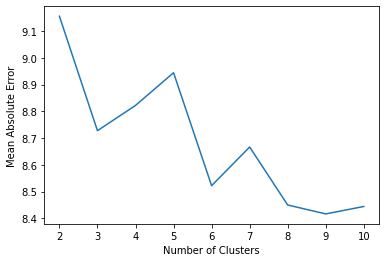

In [20]:
plt.plot(range(2, 11), mae_values) #plotting and showing mae's
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Mean Absolute Error")
plt.show()

Starting the use of modal with best k value.

In [21]:
knn = KNN(9) #best k value is 9
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
knn.score(X_test, y_test)

0.044444444444444446

In [22]:
print("Mean Absolute Error:" , mean_absolute_error(prediction,y_test))

Mean Absolute Error: 8.416666666666666


### Weighted KNN

In [23]:
weighted_knn = KNN(9)
weighted_knn.fit(X_train, y_train)
predictions = weighted_knn.weighted_predict(X_test) #using weighted_predict function
weighted_knn.score(X_test, y_test)

0.044444444444444446

In [24]:
print("Mean Absolute Error (Weighted):" , mean_absolute_error(predictions,y_test))

Mean Absolute Error (Weighted): 13.64643305573596


### K-Fold

There is my k fold function. This function shuffles the data and split it into k-folds. <br>
It returns the mean of the MAE's for each of them.

In [25]:
def k_fold_cv(k, X, y):
    
    X_shuffle, y_shuffle = sklearn.utils.shuffle(X, y) #shuffling the data 
    mae_list = []
    
    for j in range(k):
        
        X_test = X_shuffle[(j*(int(len(X_shuffle)/k))):((j+1)*(int(len(X_shuffle)/k)))]
        X_train = X_shuffle[((j+1)*(int(len(X_shuffle)/k))):]
        
        y_test = y_shuffle[(j*(int(len(y_shuffle)/k))):((j+1)*(int(len(y_shuffle)/k)))]
        y_train = y_shuffle[((j+1)*(int(len(y_shuffle)/k))):]
        
        knn = KNN(10)
        knn.fit(X_train, y_train)
        prediction = knn.predict(X_test)
        mae_list.append(mean_absolute_error(prediction, y_test))
    mae_list = np.array(mae_list)
    return mae_list.mean()

In [26]:
print("K-fold Mean Absolute Error:" , k_fold_cv(5,X,y))

K-fold Mean Absolute Error: 8.997777777777776


# Analysis of Project

### The Dataset

Firstly, the dataset was not in good condition. Some of the photos were belong the same person <br>
And age of same person were different in other photos. Some of photos were gray, some of were colored. <br>


### Methods

I convert all photos to gray because photo shapes were different. For modal, other filters <br> 
make learning easily and it's good for modal. So I used Entropy and Blur filters. <br> <br>
For using images, we have to normalize them. I prepare images for modal and normalize all of them. <br>
I took ages from dataframe and convert into array. <br> <br>

### Implementation

I have created a KNN class and write K-Nearest Neighbor algorithm voids into this class. <br>
For weighted KNN, i implemented a weighted_predict method. My KNN class was ready. <br>

After implementation of KNN, I created my mean_absolute_error function. <br> It calculates the difference of
modals predictions and the real values. 

### K Value Decision

I plotted graph for every value of K and showed mean absolute error values. I decided the best k value <br>
Then with my k value, I ran the modals KNN and weighted-KNN, I printed the MAE's. <br> <br>
I created a cross validation method and split data into k folds. <br> I calculated the MAE again with cv.

### Results

Here is Mean Absolute Error Values:

| KNN | Weighted KNN | KNN (cross_val) |
| --- | --- | --- |
| 8.41 | 13.6 | 8.99 |

My modal was not perfectly correct but some of predictions were close the real ages. <br>

#### Filter Results

In [27]:
T = entropy_list
T = [np.concatenate(i) for i in T]
N = blur_list
N = [np.concatenate(i) for i in N]

In [28]:
print("Entropy Mean Absolute Error:" , k_fold_cv(9,T,y))
print("Blur Mean Absolute Error:" , k_fold_cv(9,N,y))

Entropy Mean Absolute Error: 9.923333333333334
Blur Mean Absolute Error: 9.928888888888888


| Entropy | Blur
|:---:| ---
| __9.92__ | __9.92__

__There are mean absolute errors of my filters. We can say that after this filters, <br> 
normalizing helped us to decrease the error.__ 

__And our filters scored nearly same error value.__